In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import talib
import mplfinance as mpf
import numpy as np

In [2]:
# 語法是 yf.download(
#    股票代號,
#    start=開始日期,
#    end=完結日期,
#    period = 
#    )
df= yf.download('2330.TW', period= '3mo', interval = '1d')

[*********************100%***********************]  1 of 1 completed


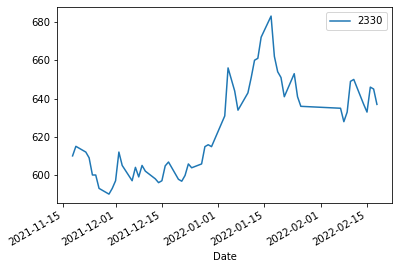

In [3]:
#走勢圖
fig = plt.figure()
df['Adj Close'].plot(label="2330")
plt.legend()

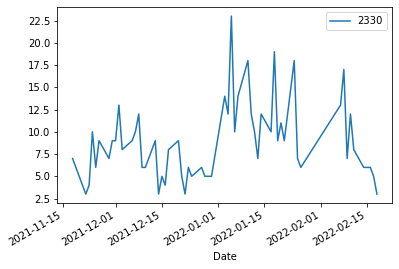

In [4]:
#每日波動
fig = plt.figure()
df['High-Low'] = df['High']-df['Low']
df['High-Low'].plot(label="2330")
plt.legend()

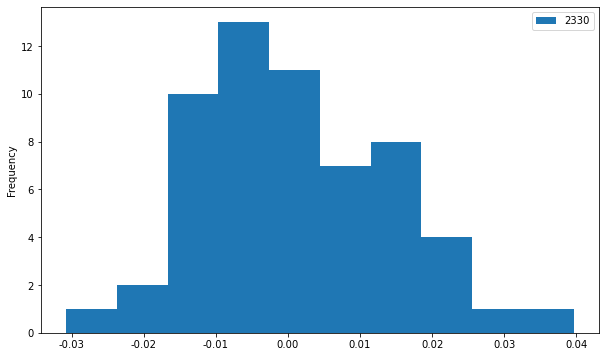

In [5]:
#每日收益率分布 (股票在一天交易中的價值變化百分比)
plt.rcParams['axes.unicode_minus']=False
fig = plt.figure(figsize=(10, 6))
df['daily-return'] = df['Adj Close'].pct_change()
df['daily-return'].plot(label="2330", kind='hist')
plt.legend()

C:\Users\User\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


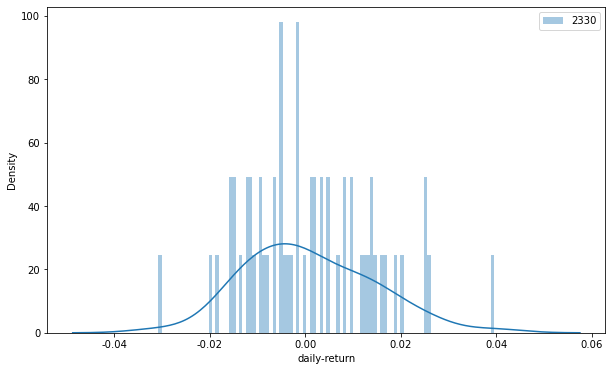

In [6]:
#日收益率 - kde密度圖
fig = plt.figure(figsize=(10, 6))
df['daily-return'] = df['Adj Close'].pct_change()
sns.distplot(df['daily-return'].dropna(),bins=100, label="2330")
plt.legend()

In [7]:
#KD
df['k'], df['d'] = talib.STOCH(df['High'], df['Low'], df['Close'],fastk_period=9,
                                         slowk_period=3,
                                         slowk_matype=1,
                                         slowd_period=3,
                                         slowd_matype=1)

#布林通道
df["upper"],df["middle"],df["lower"] = talib.BBANDS(df["Close"], timeperiod=20, nbdevup=2.1, nbdevdn=2.1, matype=0)

In [8]:
#前一日KD線
df['K-1']=df['k'].shift(1)
df['D-1']=df['d'].shift(1)

#K線突破D線買進
buy = []
for i in range(len(df)):
    if df["K-1"][i] < df["D-1"][i] and df["k"][i] > df["d"][i]:
        buy.append(1)
    else:
        buy.append(0)
df['buy'] = buy

sell = []
for i in range(len(df)):
    if df['K-1'][i] > df['D-1'][i] and df['k'][i] < df['d'][i]:
        sell.append(-1)
    else:
        sell.append(0)
df['sell']=sell

In [9]:
#添加圖示 在值上下方
buy_mark = []
for i in range(len(df)):
    if df['buy'][i] == 1:
        buy_mark.append(df['High'][i]+3)
    else:
        buy_mark.append(np.nan)
df['buy_mark'] = buy_mark

sell_mark = []
for i in range(len(df)):
    if df['sell'][i] == -1:
        sell_mark.append(df['Low'][i]-3)
    else:
        sell_mark.append(np.nan)
df['sell_mark'] = sell_mark

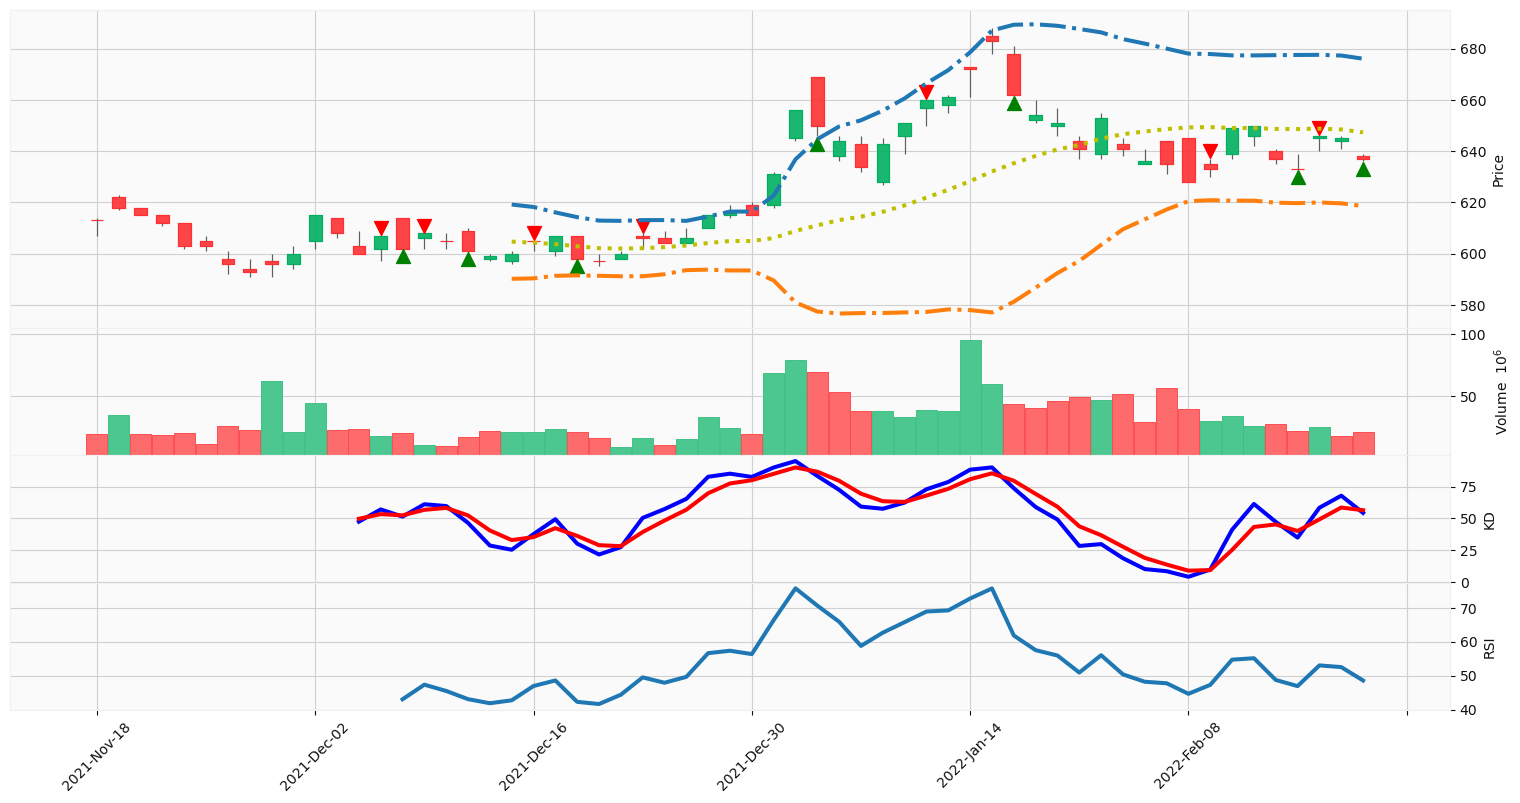

In [10]:
#繪圖

rsi = mpf.make_addplot(talib.RSI(df['Close']), panel = 3, ylabel = 'RSI')

k = mpf.make_addplot(df['k'], panel = 2, color="b",ylabel = 'KD')
d = mpf.make_addplot(df['d'], panel = 2,color="r")

B = mpf.make_addplot(df[['upper','lower']],linestyle='dashdot')
Bm= mpf.make_addplot(df['middle'],linestyle='dotted',color='y')

Buy = mpf.make_addplot(df["buy_mark"],scatter=True, markersize=100, marker='v', color='r')
Sell = mpf.make_addplot(df["sell_mark"],scatter=True, markersize=100, marker='^', color='g')   

mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

mpf.plot(df, type = 'candle' ,figsize=(20, 10), volume = True,style='yahoo', addplot = [rsi,k,d,B,Bm,Buy,Sell],show_nontrading = False)

In [11]:
#統計交易次數
buy1 = df.loc[df['buy'].isin(['1'])]
sell1 = df.loc[df['sell'].isin(['-1'])]
#sell1 = sell1.append(df[-1:]) # 最後一天無條件賣出
#buy1 = buy1.append(df[:1])# 第一天無條件買進

print(f'買進 {len(buy1)} 次')
print(f'賣出 {len(sell1)} 次')

買進 7 次
賣出 7 次


In [12]:
#報酬率
return_rate = []
for i in range(len(buy1)):
    rate = round(((sell1['Adj Close'][i] - buy1['Adj Close'][i])/buy1['Adj Close'][i])*100,2)
    return_rate.append(rate)
    
return_all = sorted(return_rate,reverse=True)
print("該策略最高報酬為 : " + str(return_all[0]) + " %")
print("該策略最低報酬為 : " + str(return_all[-1]) + " %")

該策略最高報酬為 : 7.26 %
該策略最低報酬為 : -1.39 %


In [13]:
win = len([i for i in return_rate if i > 0])
lose = len([i for i in return_rate if i <= 0])
sum_t = len(return_rate)
print("總獲利次數 : " + str(win) + "次")
print("總虧損次數 : " + str(lose) + "次")
print("總交易次數 : " + str(win + lose) + "次")
print("勝率為 : " + str(round(win / sum_t*100,2)) + "%")

總獲利次數 : 2次
總虧損次數 : 5次
總交易次數 : 7次
勝率為 : 28.57%


In [14]:
#年化報酬率
cum_return = [0]
for i in range(len(return_rate)):
    cum = round(return_rate[i] + cum_return[i],2)
    cum_return.append(cum)
print("該策略總報酬為 :" + str(cum_return[-1]) + "%")
print("該策略平均每次報酬為 : " + str(round(cum_return[-1]/(win + lose),2)) + "%")
cum_return

該策略總報酬為 :3.04%
該策略平均每次報酬為 : 0.43%


[0, -0.82, -1.97, -3.13, 4.13, 4.43, 4.43, 3.04]

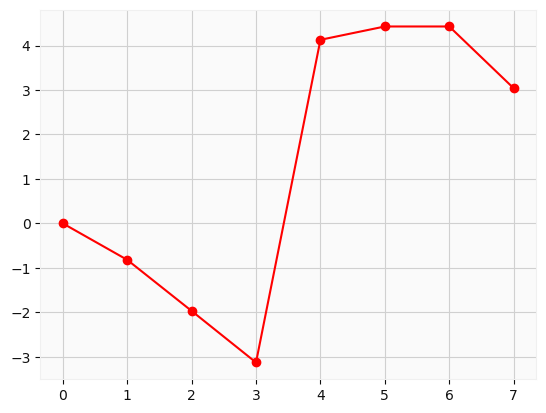

In [15]:
plt.plot(cum_return,"ro-")
plt.show()

In [16]:
#從期初持有至期末
buy_hold = []
for i in range(len(df)):
    return_h = round((df["Adj Close"].shift(-1)[i] -  df["Adj Close"][i]) / df["Adj Close"][i] * 100,2)
    buy_hold.append(return_h)
    
cum_buyhold = [0]
days = len(df)
for i in range(len(buy_hold)):
    cum = round(buy_hold[i] + cum_buyhold[i],2)
    cum_buyhold.append(cum)
print("buy&hold策略總報酬為 :" + str(cum_buyhold[-2]) + "%")
print("buy&hold的年化報酬為 :" + str(round((1 + cum_buyhold[-2])**(250/days) - 1,2)) + "%")

buy&hold策略總報酬為 :4.83%
buy&hold的年化報酬為 :1754.33%


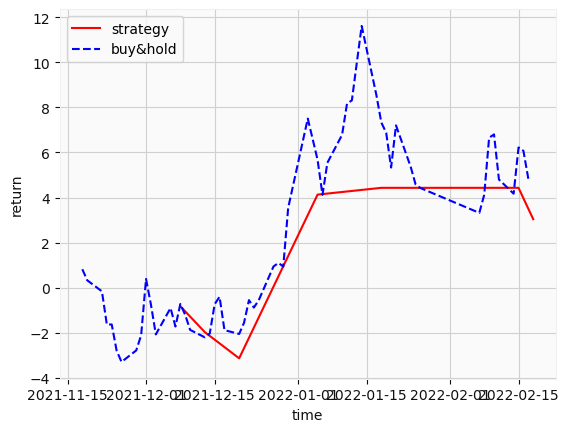

In [17]:
cum_return1 = pd.DataFrame(cum_return[1:],index = sell1.index) 
cum_buyhold1 = pd.DataFrame(cum_buyhold[1:],index = df.index)
plt.plot(cum_return1,"r-",label="strategy")
plt.plot(cum_buyhold1,"b--",label="buy&hold")
plt.xlabel("time")
plt.ylabel("return")
plt.legend(loc = 'upper left')
plt.show()

In [18]:
import pymysql

In [19]:
# Open database connection
db = pymysql.connect(
host='127.0.0.1', port=3306, user='root', passwd='dish0263', db='stock', charset='utf8')

In [20]:
cursor = db.cursor()
sql = """INSERT INTO market(
              market_date,
                 stock_no,
                 price_open, 
                 price_high,
                 price_low,
                 price_close,
                 price_adj_close,
                 volume) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)
               """

drop = """DROP TABLE market"""

create = """ CREATE TABLE market (
             market_date VARCHAR(20),
             stock_no VARCHAR(20),
             price_open VARCHAR(20), 
             price_high VARCHAR(20),
             price_low VARCHAR(20),
             price_close VARCHAR(20),
             price_adj_close VARCHAR(20),
             volume VARCHAR(20))
        """

In [21]:
df_2330= yf.download('2330.TW', period= '3mo', interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [22]:
df = df_2330.reset_index()
df['Date'] = df['Date'].astype(str)

In [23]:
df.insert(1,'stock_no',2330)

In [24]:
cursor.execute(create)

0

In [25]:
for i in range(len(df)):
    x = tuple(df.loc[i])
    cursor.execute(sql,x)

In [26]:
selectSQL = "select * from market"
cursor.execute(selectSQL)
res1 = cursor.fetchone()
print(res1)

('2021-11-18', '2330', '613.0', '614.0', '607.0', '613.0', '610.1904296875', '20030651')
